In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import datetime as dt
tf.random.set_seed(0)

In [148]:
data = pd.read_csv(r"D:\Data Science\datasets\train.csv")
# data['Date']=pd.to_datetime(data['Date'])
# #data['Date_val'] = data['Date'].map(dt.datetime.toordinal)
# data.drop('Unnamed: 0',inplace=True,axis=1)
display(data.describe())
q3, q1 = np.percentile(data.Sales,[75,25])
iqr = 1.5*(q3 - q1)
mean_sales = data.Sales.mean()

data.loc[data['Sales'] > iqr] = mean_sales
display(data.describe())

Row ID   Postal Code         Sales
count  9800.000000   9789.000000   9800.000000
mean   4900.500000  55273.322403    230.769059
std    2829.160653  32041.223413    626.651875
min       1.000000   1040.000000      0.444000
25%    2450.750000  23223.000000     17.248000
50%    4900.500000  58103.000000     54.490000
75%    7350.250000  90008.000000    210.605000
max    9800.000000  99301.000000  22638.480000

Row ID   Postal Code        Sales
count  9800.000000   9794.000000  9800.000000
mean   3988.695445  44577.302263    97.226240
std    3141.373893  36068.104784    91.424288
min       1.000000    230.769059     0.444000
25%     670.750000  10009.500000    17.248000
50%    3714.500000  40324.000000    54.490000
75%    6754.250000  80090.750000   210.605000
max    9800.000000  99301.000000   289.800000

In [149]:
dataset_summary = pd.DataFrame({"Date" : "The date on which trade occured", "Open" : "Day's Opening trading price", "High" : "Day's highest trading price",
                   "Low" : "Day's lowest trading price", "Close*" : "Day's Closing trading price", "Adj Close**" : "Day's Closing trading price after adjustustments",
                   "Volume" : "Quantity of stocks sold between open and close"},index=["Description"])
display(pd.DataFrame.transpose(dataset_summary))

Description
Date                          The date on which trade occured
Open                              Day's Opening trading price
High                              Day's highest trading price
Low                                Day's lowest trading price
Close*                            Day's Closing trading price
Adj Close**  Day's Closing trading price after adjustustments
Volume         Quantity of stocks sold between open and close

In [150]:
# #sns.heatmap(data.corr(),annot=True)
# fig = plt.figure(figsize=(15,10))

# for i in range(1,len(data.columns)):    
#     plt.subplot(3,2,i)
#     plt.scatter(data['Date'],data[data.columns[i]])
#     plt.xlabel('Date')
#     plt.ylabel(data.columns[i])
# plt.show()

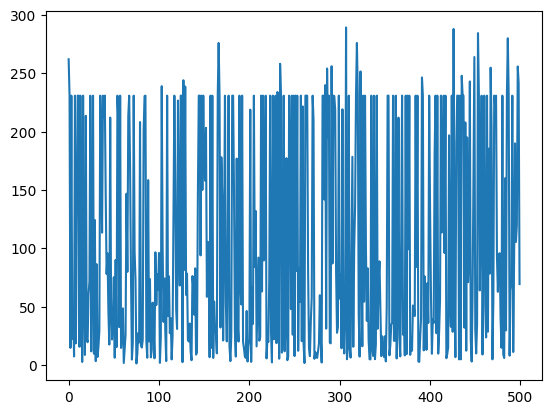

In [151]:
open_price = data[['Sales']].values.astype('float32')[:500]
plt.plot(open_price)

In [152]:
ss = MinMaxScaler(feature_range=(0,1))
open_price = ss.fit_transform(open_price)

In [153]:
train_size = round(len(open_price)*0.67)
test_size = len(open_price) - train_size
train, test = open_price[:train_size], open_price[train_size:len(open_price)]

In [154]:
def create_dataset(dataset, lookback):
    X, y = [], []

    for i in range(len(dataset)-lookback-1):
        X.append(dataset[i:i+lookback])
        y.append(dataset[i+lookback])
    
    return np.array(X), np.array(y)

In [155]:
lookback = 6
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(328, 6, 1) (328, 1)
(158, 6, 1) (158, 1)


In [156]:
model = Sequential()
model.add(LSTM(6,input_shape=(lookback,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,epochs=25,batch_size=4,verbose=2)

Epoch 1/25
82/82 - 3s - loss: 0.1113 - 3s/epoch - 31ms/step
Epoch 2/25
82/82 - 0s - loss: 0.1058 - 289ms/epoch - 4ms/step
Epoch 3/25
82/82 - 0s - loss: 0.1046 - 300ms/epoch - 4ms/step
Epoch 4/25
82/82 - 0s - loss: 0.1030 - 311ms/epoch - 4ms/step
Epoch 5/25
82/82 - 1s - loss: 0.1022 - 613ms/epoch - 7ms/step
Epoch 6/25
82/82 - 0s - loss: 0.1020 - 467ms/epoch - 6ms/step
Epoch 7/25
82/82 - 0s - loss: 0.1010 - 488ms/epoch - 6ms/step
Epoch 8/25
82/82 - 1s - loss: 0.1022 - 533ms/epoch - 6ms/step
Epoch 9/25
82/82 - 0s - loss: 0.1010 - 353ms/epoch - 4ms/step
Epoch 10/25
82/82 - 0s - loss: 0.1003 - 276ms/epoch - 3ms/step
Epoch 11/25
82/82 - 0s - loss: 0.1002 - 260ms/epoch - 3ms/step
Epoch 12/25
82/82 - 0s - loss: 0.1003 - 255ms/epoch - 3ms/step
Epoch 13/25
82/82 - 0s - loss: 0.1002 - 235ms/epoch - 3ms/step
Epoch 14/25
82/82 - 0s - loss: 0.1002 - 234ms/epoch - 3ms/step
Epoch 15/25
82/82 - 0s - loss: 0.1003 - 268ms/epoch - 3ms/step
Epoch 16/25
82/82 - 0s - loss: 0.1011 - 267ms/epoch - 3ms/step
Epo

In [157]:
train_pred = model(X_train)
test_pred = model(X_test)
train_pred = ss.inverse_transform(train_pred)
test_pred = ss.inverse_transform(test_pred)
y_train = ss.inverse_transform(y_train)
y_test = ss.inverse_transform(y_test)

train_acc = np.sqrt(mean_squared_error(y_train,train_pred))
test_acc = np.sqrt(mean_squared_error(y_test,test_pred))
print(r2_score(y_train,train_pred))
print(r2_score(y_test,test_pred))

-0.003934086738653031
-0.015679432141208816


In [158]:
# shift train predictions for plotting
train_plot = np.ones_like(open_price) * np.nan
open_price = ss.inverse_transform(open_price)
train_plot[lookback:train_size-1] = train_pred
# shift test predictions for plotting
test_plot = np.ones_like(open_price) * np.nan
test_plot[train_size+lookback:len(open_price)-1] = test_pred

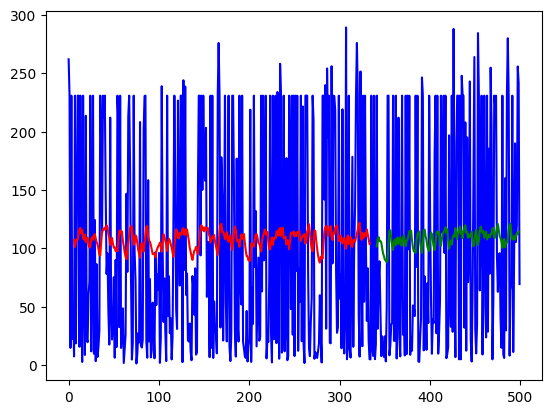

In [159]:
# plot
plt.plot(open_price, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
#print(test_plot[75:])
#print(open_price)
plt.show()

## Appendix

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/